In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [23]:
# Reading the File
df = pd.read_csv('/Users/jacksonsorenson/Documents/Ecommerce Data Project/Original CSV/data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [24]:
# Seeing the Revenu Per Product
df['Revenue'] = df['Quantity'] * df['UnitPrice']
top_10_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending = False).head(10)
print(top_10_products)

Description
DOTCOM POSTAGE                        1237472.88
REGENCY CAKESTAND 3 TIER               988573.14
WHITE HANGING HEART T-LIGHT HOLDER     598010.82
PARTY BUNTING                          590246.37
JUMBO BAG RED RETROSPOT                554136.18
RABBIT NIGHT LIGHT                     400539.54
POSTAGE                                397383.84
PAPER CHAIN KIT 50'S CHRISTMAS         382751.64
ASSORTED COLOUR BIRD ORNAMENT          353758.38
CHILLI LIGHTS                          322608.36
Name: Revenue, dtype: float64


Invalid date entries found:
        InvoiceNo StockCode                          Description  Quantity  \
2163274       NaN    17084N      LASER CUT MULTI STRAND NECKLACE         8   
2163275       NaN     21397     PAINTED LIGHTBULB RAINBOW DESIGN         7   
2163276       NaN    90201A         OLD ROSE COMBO BEAD NECKLACE         3   
2163277       NaN    90185B      S/4 BLACK DISCO PARTITION PANEL        17   
2163278       NaN     23185         SET/3 POLKADOT STACKING TINS         1   
...           ...       ...                                  ...       ...   
3244479       NaN     21078         LANDMARK FRAME BAKER STREET         14   
3244480       NaN    72801D                BLUE DINER WALL CLOCK        12   
3244481       NaN     35648  FLOWER GLASS GARLD NECKL36"TURQUOIS        19   
3244482       NaN     23225     KEY RING BASEBALL BOOT ASSORTED         23   
3244483       NaN    90195A           FAIRY CAKE DESIGN UMBRELLA        15   

        InvoiceDate  UnitPrice  Cus

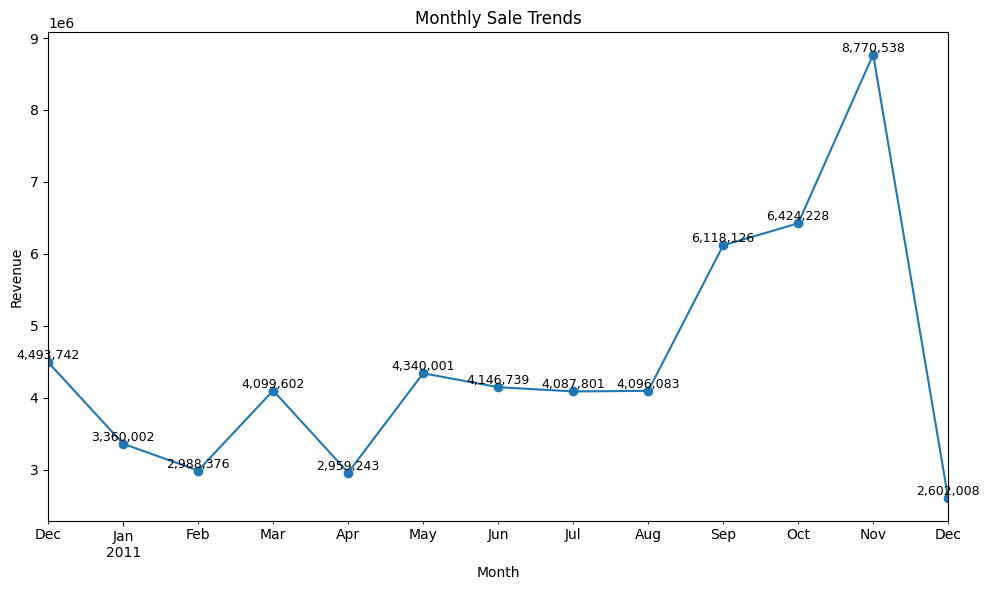

In [25]:
#Cleaning the Data, Creating a Readbale Date Time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

invalid_dates = df[df['InvoiceDate'].isna()]
if not invalid_dates.empty:
    print("Invalid date entries found:")
    print(invalid_dates)

# Grouping by Month to see Monthly Revenue
df = df.dropna(subset=['InvoiceDate'])
sales_trends = df.groupby(df['InvoiceDate'].dt.to_period('M'))['Revenue'].sum()
sales_trends.index = sales_trends.index.to_timestamp()
plt.figure(figsize=(10, 6))
sales_trends.plot(kind='line', title='Monthly Sale Trends', ylabel='Revenue', xlabel='Month', marker='o')


for i, value in enumerate(sales_trends):
    plt.text(
        sales_trends.index[i], 
        value, 
        f'{value:,.0f}', 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [26]:
#Total Price 
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

#customer ID Grroup By for Clustering, Aggregated
customer_data = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index()

print(customer_data.head())

   CustomerID  Quantity  TotalPrice
0     12346.0         0        0.00
1     12347.0     14748    25860.00
2     12348.0     14046    10783.44
3     12349.0      3786    10545.30
4     12350.0      1182     2006.40


In [27]:
# Selecting Features
features = customer_data[['Quantity', 'TotalPrice']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

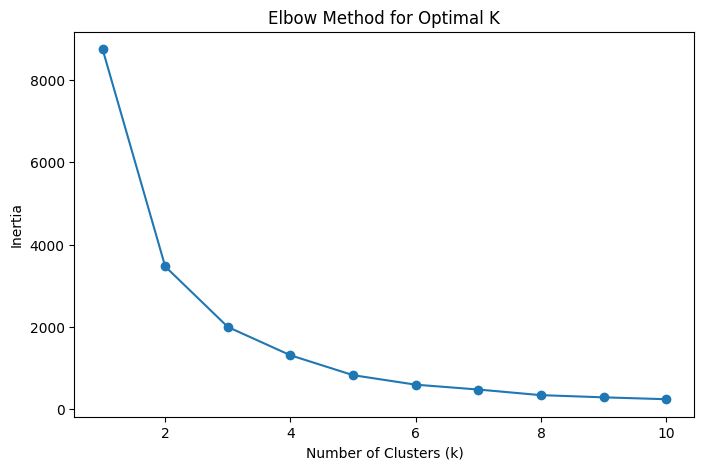

In [28]:
# Finding the Optimal Number of Clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [29]:
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Inspect the clusters
print(customer_data[['CustomerID', 'Quantity', 'TotalPrice', 'Cluster']])


      CustomerID  Quantity  TotalPrice  Cluster
0        12346.0         0        0.00        0
1        12347.0     14748    25860.00        0
2        12348.0     14046    10783.44        0
3        12349.0      3786    10545.30        0
4        12350.0      1182     2006.40        0
...          ...       ...         ...      ...
4367     18280.0       270     1083.60        0
4368     18281.0       324      484.92        0
4369     18282.0       588     1059.60        0
4370     18283.0      8382    12569.28        0
4371     18287.0      9516    11023.68        0

[4372 rows x 4 columns]


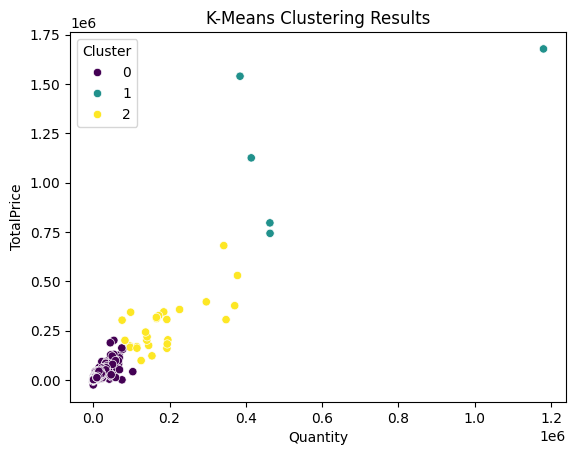

In [30]:
# Plotting the Clusters
sns.scatterplot(data=customer_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Quantity')
plt.ylabel('TotalPrice')
plt.show()


In [31]:
# Count the number of customers in each cluster
cluster_counts = customer_data['Cluster'].value_counts()

# Add formatted TotalPrice values to the summary
cluster_summary = customer_data.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Quantity': 'mean',
    'TotalPrice': 'mean'
}).rename(columns={'CustomerID': 'Count of Customers'})

# Format TotalPrice for readability
cluster_summary['TotalPrice'] = cluster_summary['TotalPrice'].apply(lambda x: f"${x:,.2f}")

print(cluster_summary)


         Count of Customers       Quantity     TotalPrice
Cluster                                                  
0                      4340    4974.652535      $8,425.63
1                         5  581150.400000  $1,175,649.30
2                        27  183169.777778    $272,404.66


In [32]:
#Viewing Cluster 0
cluster_0_data = customer_data[customer_data['Cluster'] == 0]
print(cluster_0_data.head())

   CustomerID  Quantity  TotalPrice  Cluster
0     12346.0         0        0.00        0
1     12347.0     14748    25860.00        0
2     12348.0     14046    10783.44        0
3     12349.0      3786    10545.30        0
4     12350.0      1182     2006.40        0


In [33]:
#Viewing Cluster 2
cluster_1_data = customer_data[customer_data['Cluster'] == 1]
print(cluster_1_data.head())

      CustomerID  Quantity  TotalPrice  Cluster
55       12415.0    463452   742352.70        1
1703     14646.0   1180314  1676934.12        1
1895     14911.0    463080   795435.72        1
3758     17450.0    414174  1124893.02        1
4233     18102.0    384732  1538630.94        1


In [34]:
#Viewing Cluster 2
cluster_2_data = customer_data[customer_data['Cluster'] == 2]
print(cluster_2_data.head())

     CustomerID  Quantity  TotalPrice  Cluster
330     12748.0    145260   174432.60        2
436     12901.0    125490    97758.60        2
458     12931.0    140262   200776.86        2
564     13081.0    114126   167786.88        2
568     13089.0    184722   344315.28        2


In [35]:

df = df.merge(customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='left')

# Seeing Most Popular Items Based on Descriptions
product_cluster_analysis = df.groupby(['Cluster', 'Description'])['Quantity'].sum().reset_index()

top_products_by_cluster = product_cluster_analysis.sort_values(['Cluster', 'Quantity'], ascending=[True, False])

print(top_products_by_cluster)

top_5_products = top_products_by_cluster.groupby('Cluster').head(5)
print(top_5_products)



      Cluster                         Description  Quantity
3760      0.0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    186768
1750      0.0             JUMBO BAG RED RETROSPOT    179076
215       0.0       ASSORTED COLOUR BIRD ORNAMENT    162414
3672      0.0  WHITE HANGING HEART T-LIGHT HOLDER    142860
2251      0.0     PACK OF 72 RETROSPOT CAKE CASES    137166
...       ...                                 ...       ...
6620      2.0      CREAM SWEETHEART MAGAZINE RACK       -12
8782      2.0         WOODEN BOX ADVENT CALENDAR        -30
8146      2.0     SET 2 TEA TOWELS I LOVE LONDON        -42
6624      2.0                     CRUK Commission       -96
6762      2.0                            Discount     -6732

[8877 rows x 3 columns]
      Cluster                         Description  Quantity
3760      0.0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    186768
1750      0.0             JUMBO BAG RED RETROSPOT    179076
215       0.0       ASSORTED COLOUR BIRD ORNAMENT    162414
3672      0.0  

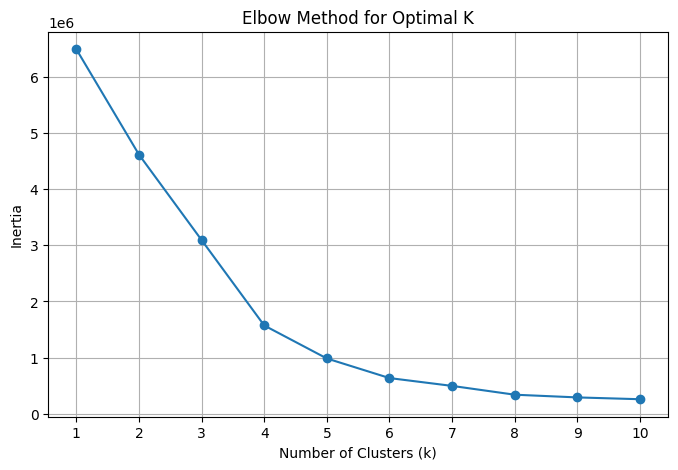

In [37]:
#Using Elbow Curve to see Optimal Clusters to Run
k_range = range(1, 11)  
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)  
plt.grid(True)       
plt.show()

In [42]:
# Use only Quanitiy for Clustering
features = df[['Quantity']] 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# KMeans clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

In [43]:
customer_data['UnitPrice'] = df['UnitPrice']

# Inspect the updated customer_data
print(customer_data)

      CustomerID  Quantity  TotalPrice  Cluster  UnitPrice
0        12346.0         0        0.00        0       2.55
1        12347.0     14748    25860.00        0       3.39
2        12348.0     14046    10783.44        0       2.75
3        12349.0      3786    10545.30        0       3.39
4        12350.0      1182     2006.40        0       3.39
...          ...       ...         ...      ...        ...
4367     18280.0       270     1083.60        0       2.10
4368     18281.0       324      484.92        0       1.65
4369     18282.0       588     1059.60        0       1.25
4370     18283.0      8382    12569.28        0       1.25
4371     18287.0      9516    11023.68        0       4.95

[4372 rows x 5 columns]


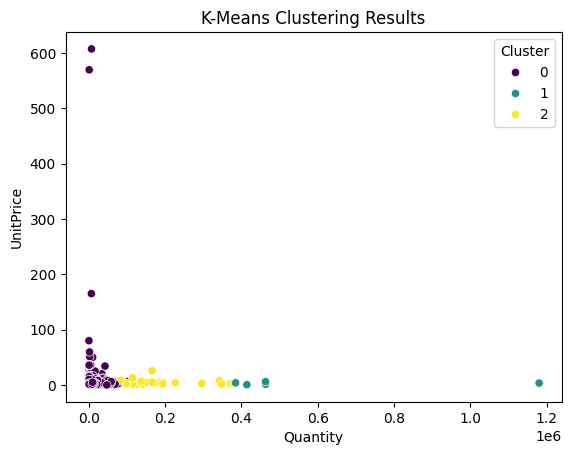

In [44]:
#Plotting K-Mean Results
sns.scatterplot(data=customer_data, x='Quantity', y='UnitPrice', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.show()
